# Other Algorithms

In this notebook, a standard K-means clustering algorithm is used. K-means has the advantage that new data points can be added and their cluster predicted after training the model. This means the model can be trained quickly for less memory using a subset of the data. 

This notebook touches on the discussion of what the requirements should be to select an algorithm for unsupervised dominant balance identification. 

First, the same preprocessing is done, as in the ```Boundary_Layer``` Notebook.

In [1]:
import numpy as np
from numpy.random import randint
import h5py
import sys
import os
from sklearn.cluster import KMeans
from sklearn.decomposition import SparsePCA
from scipy.optimize import curve_fit, root
from scipy.integrate import odeint


# adding Tools to the system path
sys.path.insert(0, "../Tools/")
import plot_funcs as pf
import preprocessing as pp
import blasius_solution as bs

# 1. Preprocessing

## a. Load the data

In [2]:
cur_dir = os.getcwd()
proj_dir = os.path.dirname(cur_dir)
plots_dir = os.path.join(proj_dir, "Plots/BL")
os.makedirs(plots_dir, exist_ok=True)

In [3]:
# Load the data from http://turbulence.pha.jhu.edu/Transition_bl.aspx
file = h5py.File("../Data/Transition_BL_Time_Averaged_Profiles.h5", "r")

In [4]:
# Get arrays for variables and the Reynold's averages
x = np.array(file["x_coor"])
y = np.array(file["y_coor"])
u_bar = np.array(file["um"])
v_bar = np.array(file["vm"])
p_bar = np.array(file["pm"])
R_uu = np.array(file["uum"]) - u_bar**2
R_uv = np.array(file["uvm"]) - u_bar * v_bar

In [5]:
# Visualize by wall-normal Reynolds stress
X, Y = np.meshgrid(x, y)

# Include line of 99% of free flow mean velocity
# Values from http://turbulence.pha.jhu.edu/docs/README-transition_bl.pdf
U_inf = 1
nu = 1 / 800
Re = (U_inf / nu) * x

## b. Get the finite difference derivatives to estimate the gradients

__NOTE: VARIABLE STEP SIZE IN Y DIRECTION ONLY__

In [6]:
# Get space steps

dx = x[1] - x[0]
dy = y[1:] - y[:-1]

nx = len(x)  # Number of points in x
ny = len(y)  # Number of points in y

# Get the derivatives
u_x, u_y, lap_u, v_y, p_x, R_uux, R_uvy = pp.get_derivatives_numpy(
    nx, ny, dx, y, u_bar, y, p_bar, R_uu, R_uv
)

# Flatten arrays for matrix multiplication, using fortran ordering
u_bar = u_bar.flatten("F")
v_bar = v_bar.flatten("F")
p_bar = p_bar.flatten("F")
R_uu = R_uu.flatten("F")
R_uv = R_uv.flatten("F")

# Flatten the derivative terms arrays for the rest of the notebook
lap_u = lap_u.flatten("F")
R_uux = R_uux.flatten("F")
R_uvy = R_uvy.flatten("F")
u_x = u_x.flatten("F")
u_y = u_y.flatten("F")
v_y = v_y.flatten("F")
p_x = p_x.flatten("F")

## c. Equation space representation

In [7]:
# Labels of terms in the RANS equation
labels = [
    r"$\bar{u} \bar{u}_x$",
    r"$\bar{v}\bar{u}_y$",
    r"$\rho^{-1} \bar{p}_x$",
    r"$\nu \nabla^2 \bar{u}$",
    r"$\overline{(u^\prime v^\prime)}_y$",
    r"$\overline{({u^\prime} ^2)}_x$",
]

In [8]:
# Get terms stored as features
features = 1e3 * np.vstack([u_bar * u_x, v_bar * u_y, p_x, nu * lap_u, R_uvy, R_uux]).T
nfeatures = features.shape[1]

# 2. K-Means


Again, a standard K-Means algorithm is used here, with setting the number of clusters to 6.

## a. Train the model and predict for full dataset

In [9]:
# Train K-means model

# Fit K-Means model
nc = 15  # Number of clusters
seed = 75016
model = KMeans(n_clusters=nc, n_init=10, random_state=seed)

# Train on only a subset (10%) of the data
sample_pct = 0.1
mask = np.random.permutation(features.shape[0])[: int(sample_pct * features.shape[0])]

In [10]:
# Set tanh sample weights
model.fit(features[mask, :])

KMeans(n_clusters=15, n_init=10, random_state=75016)

In [11]:
# Predict clusters for all data
clustering = model.predict(features)

# Get covariances in each cluster
covs = np.zeros((nc, nfeatures, nfeatures))
for i in range(nc):
    mask_ = clustering == i
    covs[i, :, :] = np.cov(features[mask_, :].T)

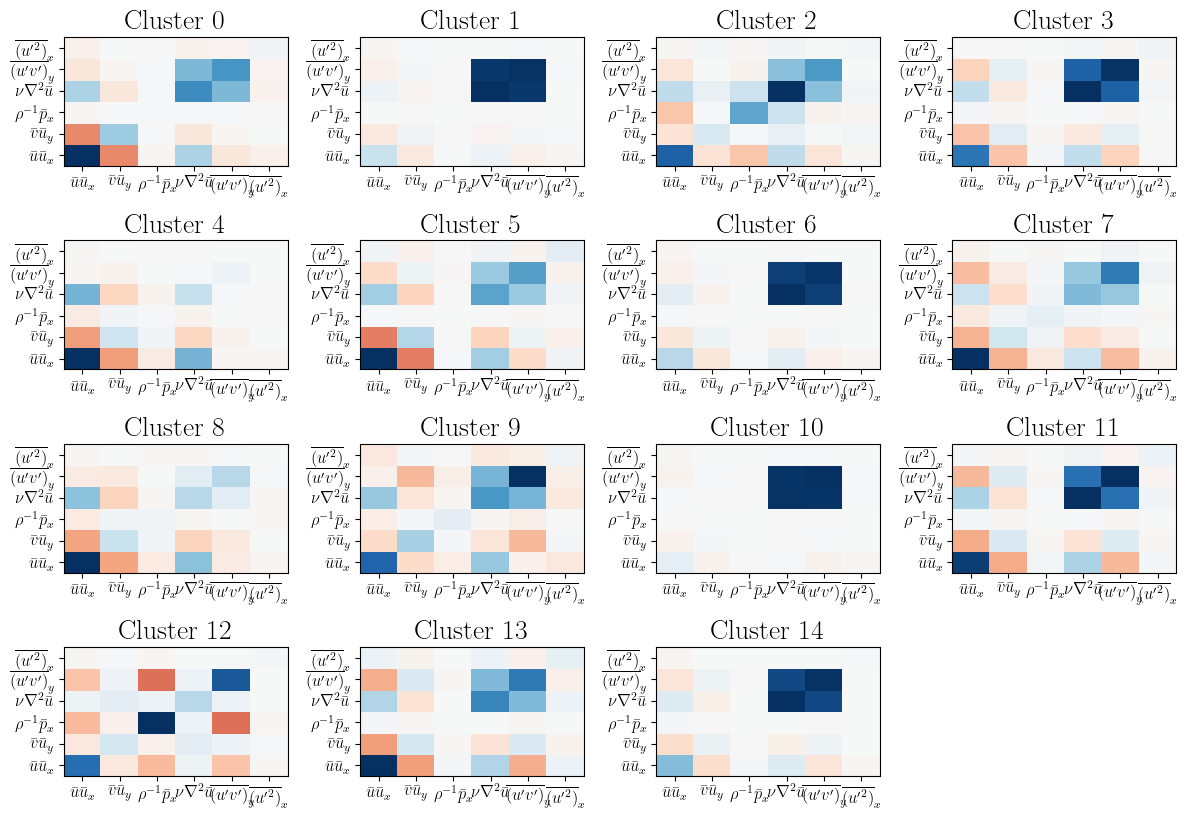

In [12]:
# Plot covariance matrices for each K-Means cluster
pf.plot_cov_mat(covs, nfeatures, nc, labels, "Other", "BL/KMeans_CovMat.png")

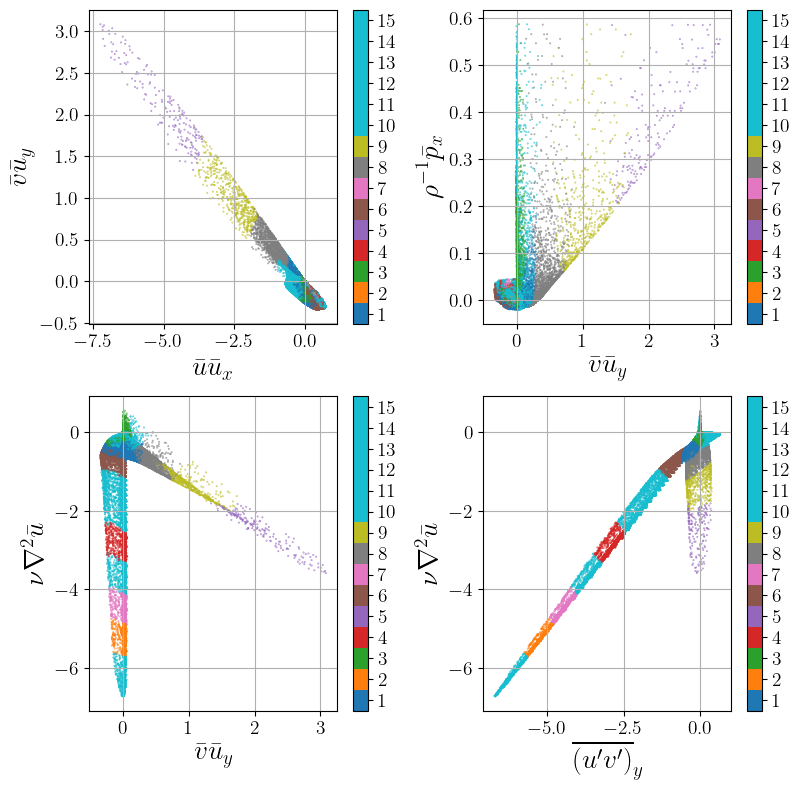

In [13]:
# Visualize GMM clustering with 2D views of equation space

cluster_idx = clustering + 1

pf.plot_clustering_2d_eq_space(
    features[mask, :], cluster_idx[mask], nc, "BL/KMeans_2D_eq_space.png"
)

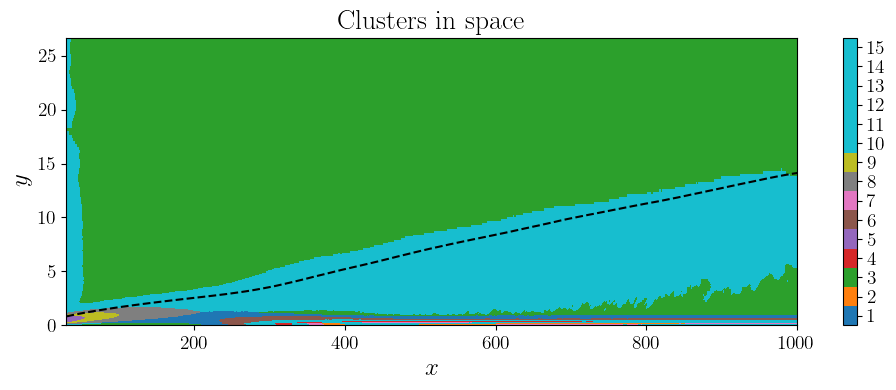

In [14]:
# Assign points in space to each cluster
cluster_idx = clustering
clustermap = np.reshape(cluster_idx, [ny, nx], order="F")

# Visualize the clustering in space
pf.plot_clustering_space(
    clustermap, x, y, X, Y, nx, ny, nc, u_bar, U_inf, "BL/KMeans_Clustering_Space.png"
)

Already, the main issue with K-means clustering for this problem can be seen. With the way points are distributed in the equation space, points close to the origin, are clustered together (orange). However, when representing that cluster in space, it includes multiple regions of the flow that have very distinct characteristics. 

This is due to K-means clustering only considering the euclidean distance between points. Thus, compared to the extreme valued points that are far apart, points close to the origin which are all much closer together are simply put in a single cluster.

## b. Sparce Principal Component Analysis (SPCA) dimensionality reduction

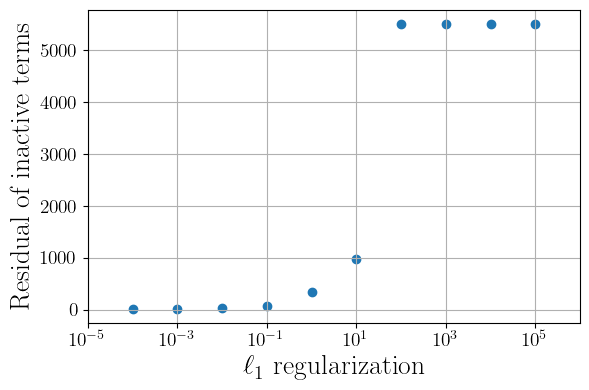

In [15]:
# Sparse PCA to identify directions of nonzero variance in each cluster

alphas = [1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1e3, 1e4, 1e5]
err = np.zeros([len(alphas)])
sparsity = np.zeros([len(alphas)])

for k in range(len(alphas)):
    for i in range(nc):
        # Identify points in the field corresponding to each cluster
        feature_idx = np.nonzero(cluster_idx == i)[0]
        cluster_features = features[feature_idx, :]

        # Conduct Sparse PCA
        spca = SparsePCA(n_components=1, alpha=alphas[k])  # normalize_components=True
        spca.fit(cluster_features)

        # Identify active and terms
        active_terms = np.nonzero(spca.components_[0])[0]
        inactive_terms = [feat for feat in range(nfeatures) if feat not in active_terms]

        # Calculate the error, as the sum of the norms of the inactive terms
        err[k] += np.linalg.norm(cluster_features[:, inactive_terms])

pf.plot_spca_residuals(alphas, err, "BL/KMeans_spca_residuals.png")

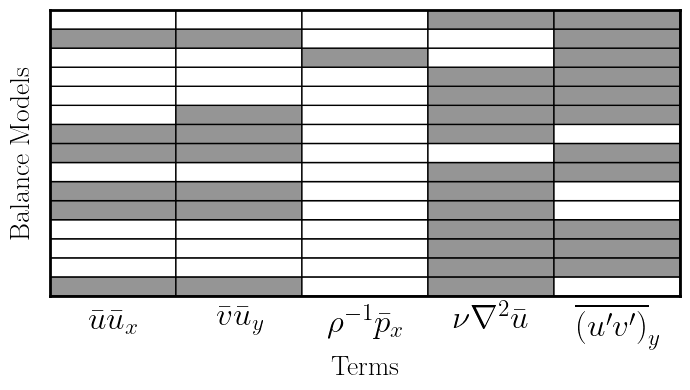

In [39]:
# Get the active terms for each cluster for optimal alpha

alpha_opt = 7  # Optimal alpha value

spca_model = np.zeros([nc, nfeatures])  # Store the active terms for each cluster

for i in range(nc):
    feature_idx = np.nonzero(cluster_idx == i)[0]
    cluster_features = features[feature_idx, :]

    spca = SparsePCA(n_components=1, alpha=alpha_opt)  # normalize_components=True
    spca.fit(cluster_features)

    active_terms = np.nonzero(spca.components_[0])[0]
    if len(active_terms) > 0:
        spca_model[i, active_terms] = 1  # Set the active terms to 1

pf.plot_balance_models(spca_model, labels, False, "BL/KMeans_active_terms.png")

## c. Resulting Final Dominant Balance Models

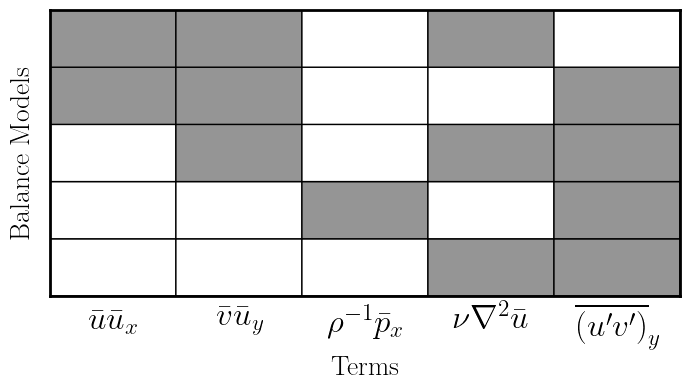

In [40]:
# Identify clusters with identical balance models
balance_models, model_index = np.unique(spca_model, axis=0, return_inverse=True)
nmodels = balance_models.shape[0]

# Make new cluster_idx based on the unique SPCA balance model
balance_idx = np.array([model_index[i] for i in cluster_idx])
balancemap = np.reshape(balance_idx, [ny, nx], order="F")

pf.plot_balance_models(
    balance_models, labels, False, "BL/KMeans_unique_active_terms.png"
)

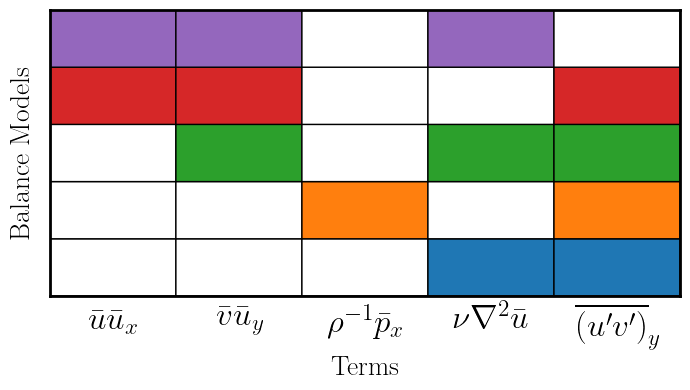

In [41]:
pf.plot_balance_models(balance_models, labels, True, "BL/KMeans_balance_models.png")

In [42]:
np.unique(balancemap)

array([0, 1, 2, 3, 4])

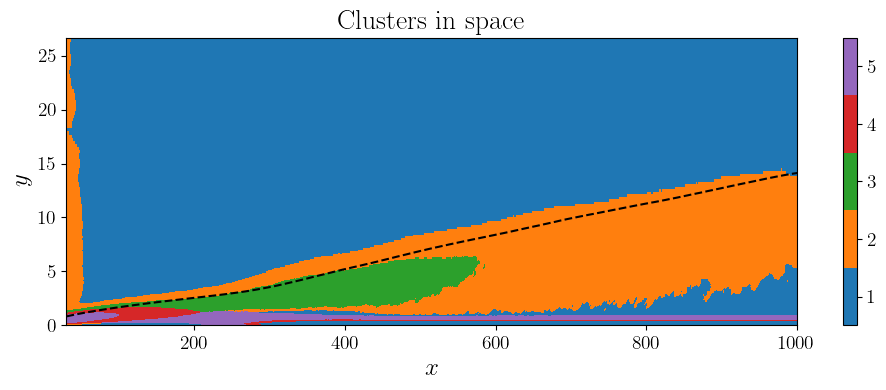

In [43]:
pf.plot_clustering_space(
    balancemap,
    x,
    y,
    X,
    Y,
    nx,
    ny,
    nmodels,
    u_bar,
    U_inf,
    "BL/KMeans_spca_clustering.png",
)

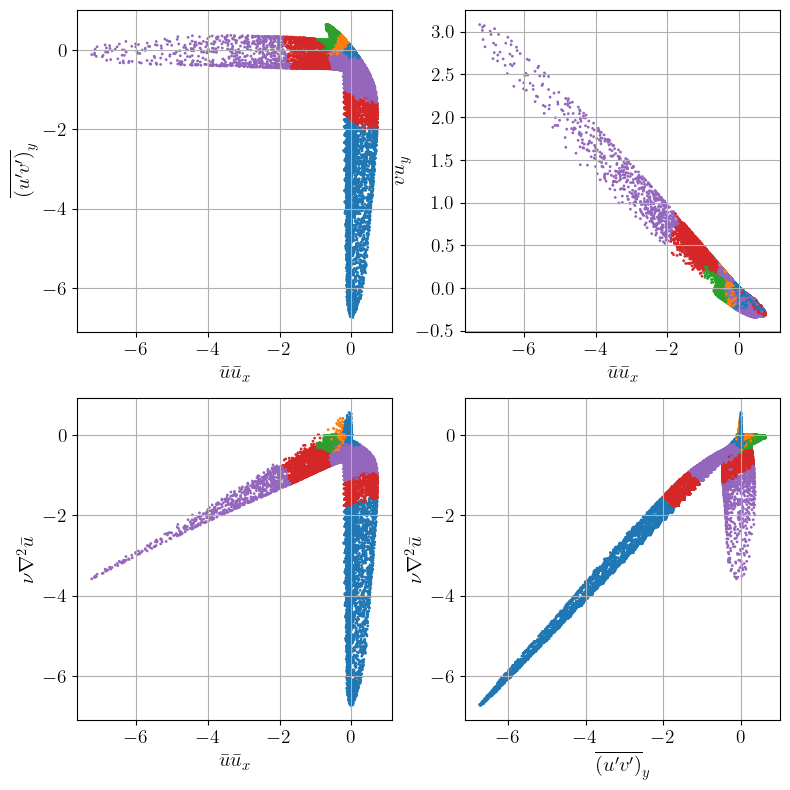

In [49]:
# 2D views of feature space
pf.plot_feature_space(
    features[mask, :], balance_idx[mask], "BL/KMeans_feature_space.png"
)

With multiple clusters being made up of the points in the "branches" observed equation space, these end up being described by the same dominant balance after applying SPCA, and therefore are grouped as one cluster. Thus, a small number of unique dominant balance models are found when using K-means.

Here, 3 are obtained, the viscous sublayer in blue, the inflow region with low Reynold's stress (green), and the rest of the flow is characterised by a balance between the viscous forces, the Reynold's stress and the 2 fluxes $\bar{u}\bar{u}_x$, $\bar{v}\bar{u}_y$.


## Outer Layer Scaling

The length scale of the outer layer should scale with $ \ell \sim x^{4/5} $ (see pg 71 in Holmes, Lumley, Berkooz or pg 638 in Schlichting)

As a rough diagnostic of our balance model, define the outer layer length scale as the wall-normal coordinate where the balance changes from the inertial sublayer to the free-stream (once the transitional region has disappeared).

[]
[2.64879492e+01 9.88455260e-09]


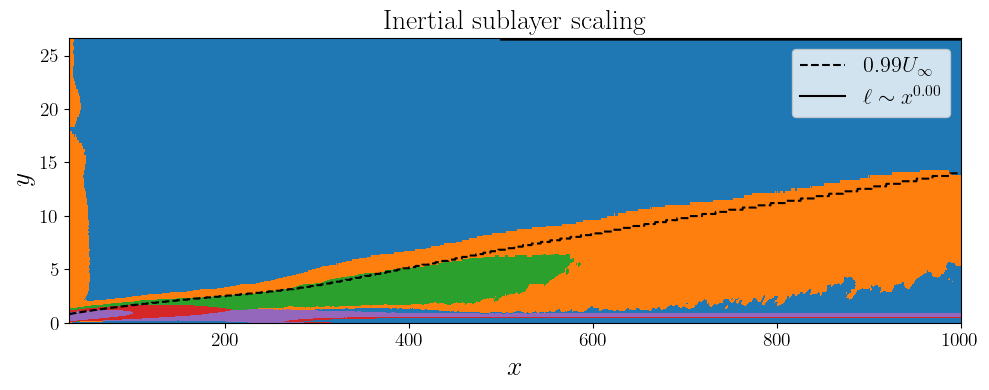

In [45]:
# Create a u_bar field:
u_map = np.reshape(u_bar, (ny, nx), order="F")

# Find which cluster is the inertial sublayer.
inert_sub_idx = np.where(np.all(balance_models == [1, 0, 0, 0, 1, 0], axis=1))[0] + 1
print(inert_sub_idx)
inert_sub_idx = 4

# Define some variables
x_min = 110  # Where inertial balance begins
x_turb = 500  # Where transitional region ends

x_idx = np.nonzero(x > x_min)[0]
x_layer = x[x_idx]

# First, find the upper extent of the inertial sublayer
y_gmm = np.zeros(len(x_idx))
# Loop through wall-normal direction until the balance changes
for i in range(len(x_idx)):
    j = len(y) - 1
    while balancemap[j, x_idx[i]] == inert_sub_idx:
        j -= 1
    y_gmm[i] = y[j]  # Store upper value of inertial balance

# Next, find the 99% of free stream velocity line
delta = np.zeros(len(x))
# Loop until velocity falls past 99% freestream
for i in range(len(x)):
    j = 0
    while u_map[j, i] < 0.99:
        j += 1
    delta[i] = y[j - 1]

# Fit inertial balance to power law
power_law = lambda x, a, b: a * x**b

x_to_fit = x_layer > x_turb  # End of transitional region
p_gmm, cov = curve_fit(power_law, x_layer[x_to_fit], y_gmm[x_to_fit])
gmm_fit = power_law(x_layer, *p_gmm)
print(p_gmm)


# Plot the inertial sublayer scaling
pf.plot_sublayer_scaling(
    x,
    y,
    balancemap,
    delta,
    x_layer,
    gmm_fit,
    p_gmm,
    x_to_fit,
    "BL/KMeans_sublayer_scaling.png",
)

Since the model did not identify an inertial sublayer, but just a large cluster that combines the free stream, inertial sublayer, and transitional region, here the $l \sim x^{4/5}$ scaling is not obtained

## Self-similarity

In the near-wall region (viscous sublayer), we should be able to collapse the profiles using wall units $u^+$, $y^+$. These wall units are defined as: 
- $y^{+}=\frac{y u_{\tau}}{\nu}$, the distance $y$ to the wall, dimensionaless using friction velocity $u_{\tau}$, and kinematic viscosity $\nu$.
- $u^{+}=\frac{u}{u_{\tau}}$, the dimensonless velocity as a function of y.

Here we show that this universality breaks down at approximately the same place where the identified viscous sublayer balance ends. Therefore demonstrating the identified balance models follow fluid dynamics theory.

As shown in the figure above, the wall-normal extent of the sublayer (blue) is approximately constant in the fully-developed turbulent region. We observe below that this is given by $y^+ \sim 18$.

[Wikipedia](https://en.wikipedia.org/wiki/Law_of_the_wall)

1001.0672101707805
973.9900933537624
952.739902739125
934.4167230067761
919.7376932554381


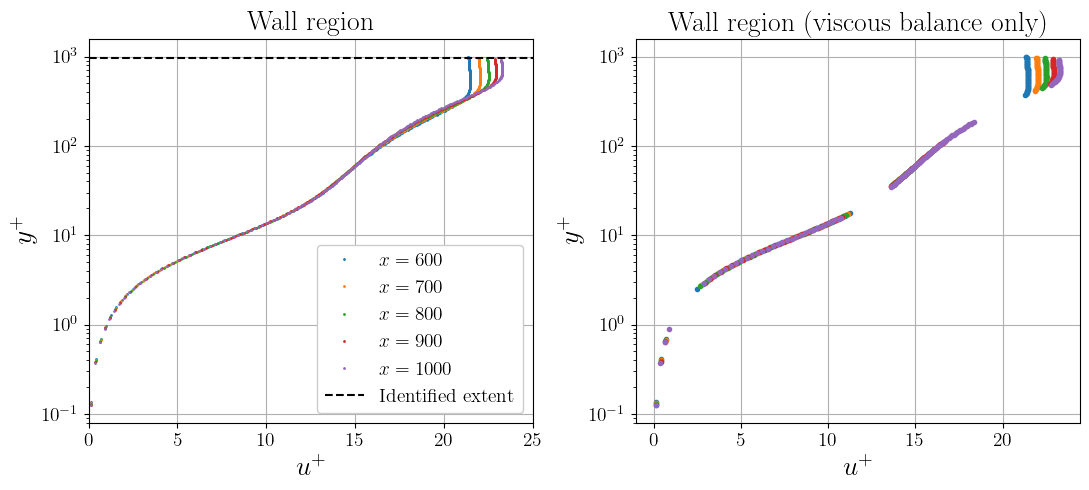

In [46]:
# Compute friction velocity with an estimate of the wall shear stress
u_tau = np.sqrt(nu * u_y[::ny])

# Define wall units
y_plus = np.outer(y, u_tau / nu)
u_plus = np.reshape(u_bar, [ny, nx], order="F") / u_tau

# Plot the self-similarity of the flow
pf.plot_self_similarity(
    x, 0, y_plus, u_plus, balancemap, "BL/KMeans_self_similarity.png"
)

Here, we see that the identified extent of the viscous sublayer is much lower than where the flow profiles diverge, where the true viscous sublayer actually ends. Thus, the K-Means algorithm did identify a viscous sublayer region but it is too shallow.

## Blasius solution in laminar regime

We also find that there is an inflow region without significant Reynolds stress (green), which suggests this flow is approximately laminar, until the clustered large (orange) region begins around $x\sim 90$.  Before that we would expect the Blasius boundary layer solution to hold.

__Blasius solution:__
$$ \eta = y \sqrt{\frac{U}{2\nu x} }$$
$$ u = U f'(\eta) $$
[Wikipedia](https://en.wikipedia.org/wiki/Blasius_boundary_layer#Blasius_equation_-_first-order_boundary_layer)

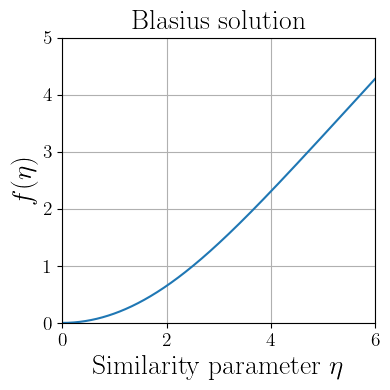

In [47]:
# Solve Blasius equations numerically

# Arbitrary "infinite" upper limit for domain
eta_inf = 200
# Step size
d_eta = 0.01
eta = np.arange(0, eta_inf, d_eta)

# Initial guess for unknown initial condition
F_init = [0, 0, 0]

# Solve root-finding problem for unknown initial condition
opt_res = root(bs.bc_fn, F_init, tol=1e-4)
F0 = [0, 0, opt_res.x[2]]

# Evaluate with resulting initial conditions
f = odeint(lambda y, t: bs.blasius_rhs(y), F0, eta)

pf.plot_blasius_solution(eta, f, "BL/KMeans_blasius_solution.png")

Then we can compare the inflow profile to the Blasius solution.

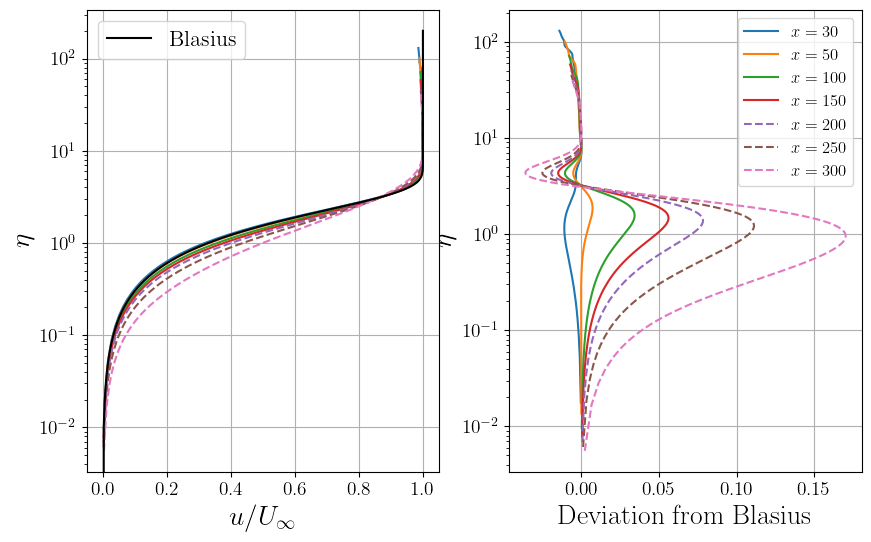

In [48]:
pf.plot_blasius_deviation(
    x, y, nx, ny, u_bar, eta, f, U_inf, nu, "BL/KMeans_blasius_deviation.png"
)

It can be seen that until $x \sim 150$ there is a maximum deviation of about 6% from the Blasius solution. This indicates that the algorithm should have likely identified a larger area for the green laminar inflow region.